In [1]:
import os
import biom
import pandas as pd
import qiime2 as q2
from biom import Table
from qiime2 import Artifact
from qiime2 import Metadata
import numpy as np
import random
import time
from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import (ctf, phylogenetic_ctf,
                                            phylogenetic_ctf_without_taxonomy)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance
from qiime2.plugins.feature_table.methods import rarefy
from skbio.stats.distance import permanova
np.random.seed(42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import data
table = q2.Artifact.load('data/filtered_table.qza')
metadata = q2.Metadata.load('data/metadata-matched.tsv')
tree = q2.Artifact.load('data/insertion-tree.qza')

# remove controls
mf = metadata.to_dataframe()
mf = mf[~mf.month.isin([0, 15, 19])]
mf = mf[mf.mom_child == 'C']
mf['host_subject_id_str'] = 'subject_' + mf['host_subject_id'].astype(int).astype(str)
# keep shared IDs
bt = table.view(Table)
shared_ = set(bt.ids()) & set(mf.index)
bt = bt.filter(shared_)

# filter out zero sums
min_feature_count = 1
min_feature_frequency = 0
n_features, n_samples = bt.shape
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
# filter features by N samples presence
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)

bt = bt.filter(observation_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > 0)])
mf = mf.reindex(bt.ids())


# re-import
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
metadata = q2.Metadata(mf)
bt

1856 x 645 <class 'biom.table.Table'> with 34171 nonzero entries (2% dense)

In [3]:
# add real data
simulation_results = {}
bt_sim_tmp = table.view(Table).copy()
rare_depth = int(np.percentile(bt_sim_tmp.sum('sample'), 25))
keep_ids = bt_sim_tmp.ids()[bt_sim_tmp.sum('sample') > rare_depth]
bt_sim_tmp = bt_sim_tmp.filter(keep_ids)
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]',
                                        bt_sim_tmp)
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]', bt_sim_tmp)
# rare for other methods
table_rare_tmp = rarefy(table_sim_tmp, rare_depth, with_replacement=True).rarefied_table
bt_sim_tmp = bt_sim_tmp.filter(table_rare_tmp.view(Table).ids('observation'), axis='observation')
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]', bt_sim_tmp)
mf_tmp = metadata.to_dataframe().copy().reindex(bt_sim_tmp.ids())
simulation_results[rare_depth] = (table_rare_tmp, table_sim_tmp, mf_tmp)

table_characteristics = {(k, ttype):[t.view(Table).shape[1],
                            t.view(Table).shape[0],
                            np.percentile(t.view(Table).sum('sample'), 25),
                            t.view(Table).sum('sample').mean(),
                            np.median(t.view(Table).sum('sample')),
                            t.view(Table).sum('sample').std() / t.view(Table).sum('sample').mean(),
                            t.view(Table).sum('sample').std(),
                            t.view(Table).sum('sample').min(),
                            t.view(Table).sum('sample').max(),
                            (t.view(Table).nnz /\
                             (t.view(Table).shape[0] * t.view(Table).shape[1])) * 100]
                         for k, tab in simulation_results.items()
                         for t, ttype in zip(tab[:-1], [True, False])}
table_characteristics = pd.DataFrame(table_characteristics, ['n-samples','n-features','rare-75%',
                                                             'mean','median',
                                                             'coeff','std','min','max','% observed']).T
table_characteristics.index.names = ['estimate-depth','rare']
table_characteristics.head(10)

n-samples  n-features  rare-75%          mean   median  \
estimate-depth rare                                                            
11939          True       483.0      1708.0   11939.0  11939.000000  11939.0   
               False      483.0      1708.0   14279.0  18356.503106  16383.0   

                        coeff          std      min      max  % observed  
estimate-depth rare                                                       
11939          True   0.00000     0.000000  11939.0  11939.0    3.073831  
               False  0.36691  6735.192349  12022.0  68174.0    3.257112

In [4]:
bt_test = simulation_results[11939][1].view(Table)
tst_btdf = pd.DataFrame(bt_test.matrix_data.toarray(),
                        bt_test.ids('observation'), bt_test.ids())
tntree = tree.view(TreeNode)
tntree = tntree.shear(bt_test.ids('observation'))
tntree.prune()

Breakdown of the box below:

simulation_results is a dictionary with only 1 key:value pair, where the key is called "11939" which is the estimated depth after rarefaction. The **value** assigned to key 11939 is a list containing
- rarefied count qiime artifact index == [0]
- non-rarefied count qiime artifact index == [1]
- metadata dataframe index == [2]

Below, the for loop actually just runs on the one "sim char:" 11939.

The rarefied data is ONLY used for non-gemelli methods, something I missed when I first started this project

In [5]:

simulation_metrics = {}
metric_time = {}

for sim_char, (table_rare_tmp, table_sim_tmp, mf_tmp) in simulation_results.items():

    # run default phylo RPCA
    
    start_time = time.time()
    phylo_ctf_tmp = phylogenetic_ctf_without_taxonomy(table_sim_tmp, tree, q2.Metadata(mf_tmp),
                                                      'host_subject_id_str', 'month', min_depth=100)
    metric_time['Phylo-CTF'] = time.time() - start_time
        
    start_time = time.time()
    # replicated from PMID: 32868914
    ctf_tmp = ctf(table_sim_tmp, q2.Metadata(mf_tmp), 'host_subject_id', 'month',
                  n_components = 2, max_iterations_rptm = 5, n_initializations = 5, max_iterations_als = 5)
    metric_time['CTF'] = time.time() - start_time
    
    # run unifrac(s)
    start_time = time.time()
    unweighted_unifrac_distance_tmp = beta_phylogenetic(table_sim_tmp, tree,
                                                    'unweighted_unifrac')
    unweighted_unifrac_pcoa_tmp = pcoa(unweighted_unifrac_distance_tmp.distance_matrix)
    metric_time['unweighted UniFrac'] = time.time() - start_time

    start_time = time.time()
    jaccard_distance_tmp = beta(table_sim_tmp, 'jaccard')
    jaccard_pcoa_tmp = pcoa(jaccard_distance_tmp.distance_matrix)
    metric_time['Jaccard'] = time.time() - start_time
    
    start_time = time.time()
    braycurtis_distance_tmp = beta(table_sim_tmp, 'braycurtis')
    braycurtis_pcoa_tmp = pcoa(braycurtis_distance_tmp.distance_matrix)
    metric_time['Bray-Curtis'] = time.time() - start_time

    unifracs_dist_tmp = {'unweighted UniFrac':unweighted_unifrac_distance_tmp.distance_matrix.view(DistanceMatrix),
                         'Jaccard':jaccard_distance_tmp.distance_matrix.view(DistanceMatrix),
                          'Bray-Curtis':braycurtis_distance_tmp.distance_matrix.view(DistanceMatrix)}
    unifracs_ord_tmp = {'unweighted UniFrac':unweighted_unifrac_pcoa_tmp.pcoa.view(OrdinationResults),
                        'Jaccard':jaccard_pcoa_tmp.pcoa.view(OrdinationResults),
                         'Bray-Curtis':braycurtis_pcoa_tmp.pcoa.view(OrdinationResults)}
    
    # save results
    distances_tmp = {'Phylo-CTF':phylo_ctf_tmp.distance_matrix.view(DistanceMatrix),
                     'CTF':ctf_tmp.distance_matrix.view(DistanceMatrix)}

    distances_tmp = {**distances_tmp, **unifracs_dist_tmp}

    ordinations_tmp = {'Phylo-CTF':[phylo_ctf_tmp.state_subject_ordination.view(pd.DataFrame),
                                    phylo_ctf_tmp.subject_biplot.view(OrdinationResults)],
                       'CTF':[ctf_tmp.state_subject_ordination.view(pd.DataFrame),
                              ctf_tmp.subject_biplot.view(OrdinationResults)]}

    ordinations_tmp = {**ordinations_tmp, **unifracs_ord_tmp}
    
    simulation_metrics[sim_char] = [distances_tmp, ordinations_tmp]

/Users/dfrybrum/anaconda3/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/gemelli/preprocessing.py:886: RuntimeWarning: Subject(s) (subject_10,subject_55,subject_31,subject_8,subject_34,subject_53,subject_5,subject_24,subject_32,subject_7,subject_16,subject_30,subject_2,subject_20,subject_4,subject_1,subject_43,subject_33,subject_57,subject_56,subject_41) contains multiple samples. Multiple subject counts will be meaned across samples by subject.
  warnings.warn(''.join(["Subject(s) (", str(duplicated_ids),
/Users/dfrybrum/anaconda3/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(matrix_closure(mat) * branch_lengths))
/Users/dfrybrum/anaconda3/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/gemelli/preprocessing.py:909: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/qiime2/dfrybrum/data/b27b5b62-28ae-413b-85a0-8aaa7661e47c/data/feature-table.biom -t /var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/qiime2/dfrybrum/data/224db336-889d-40c4-9592-93c38da68d87/data/tree.nwk -m unweighted -o /var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/q2-LSMatFormat-6sfxfrcf



/Users/dfrybrum/anaconda3/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.11559955860139685 and the largest is 18.770044570926746.
  warn(
/Users/dfrybrum/anaconda3/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See

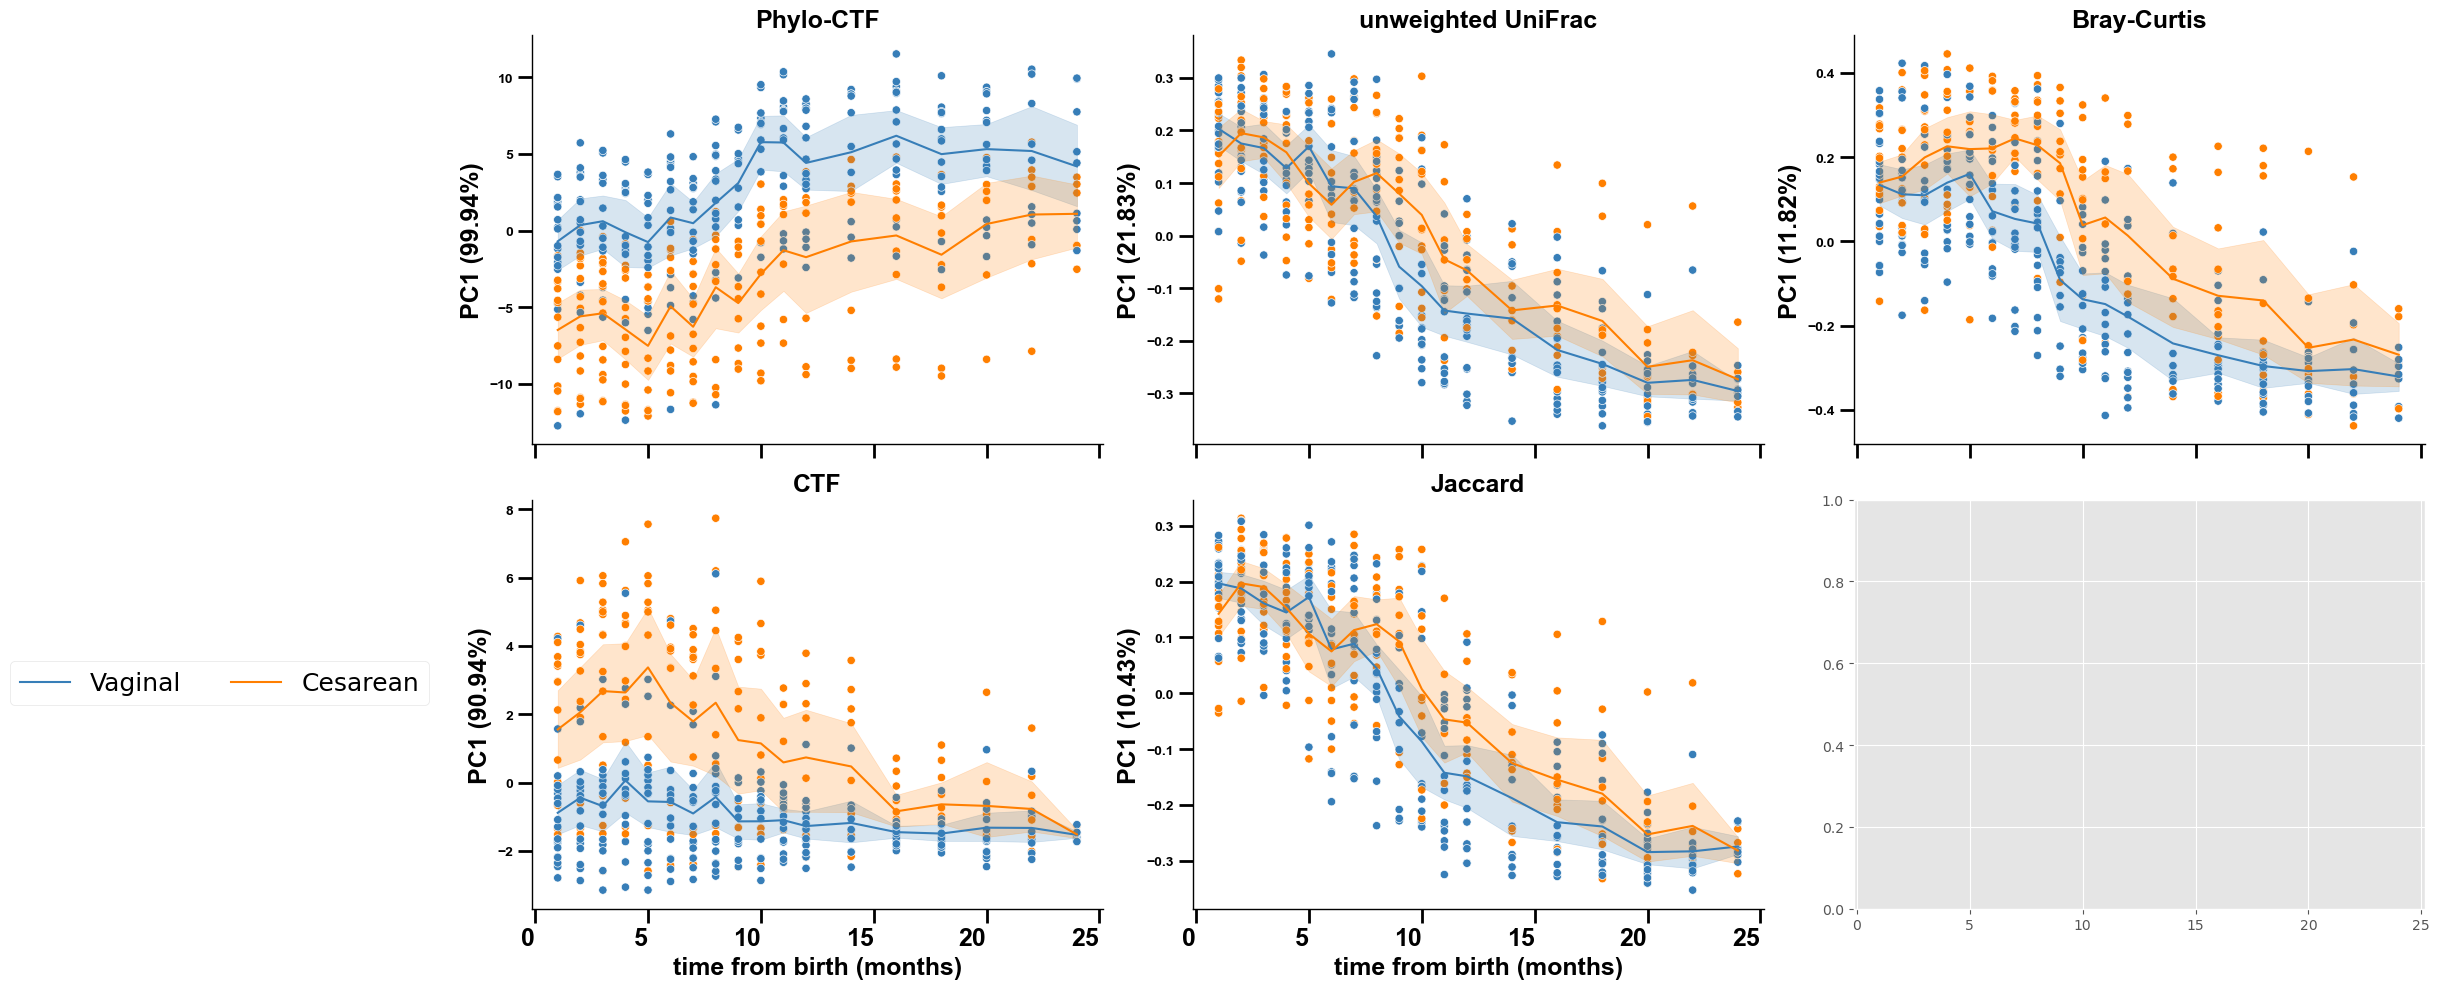

In [6]:


catagory = 'delivery'
pal_use = {'Vaginal':'#377eb8',
           'Cesarean':'#ff7f00'}


fig, axn = plt.subplots(2, 3,figsize=(20, 10), sharex=True)

simulation_metrics_plot = {}
for method, ord_ in  simulation_metrics[11939][1].items():
    if '\\alpha$=' in method:
        if (int(float(method.split('\\alpha$=')[1][:-1]) * 10) % 2 != 0) \
        & (float(method.split('\\alpha$=')[1][:-1]) != 0.1):
            continue
    simulation_metrics_plot[method] = ord_

    
for (method, ord_), ax in zip(simulation_metrics_plot.items(), axn.T.flatten()):


    if method in ['CTF', 'Phylo-CTF']:
        ord_tmp = ord_[0].copy()
        ord_tmp = ord_tmp.rename({'PC1':0,'PC2':1}, axis=1)
        ord_tmp = ord_tmp.dropna(subset=[0, catagory])
        ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
        ord_ = ord_[1]
    else:
        ord_tmp = ord_.samples[[0, 1, 2]].copy()
        mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
        ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory, 'month']]],
                            axis=1, sort=False).dropna(subset=[0, catagory])
        ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']

    sns.scatterplot(x='month', y=0, hue='delivery', data=ord_tmp, ax=ax, palette=pal_use)
    sns.lineplot(x='month', y=0, hue='delivery', data=ord_tmp, ax=ax, palette=pal_use)
    ax.set_title(method,
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.legend_.remove()
    
    
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(10)
    ax.set_xlabel('time from birth (months)',
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_ylabel('PC1 (%.2f%%)' % (ord_.proportion_explained[0] * 100 ),
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    
plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:],
          loc=2, bbox_to_anchor=(-3.25, -0.50),
          prop={'size':18},
          fancybox=True, framealpha=0.5, 
          ncol=2, markerscale=3,
          facecolor="white")

plt.savefig('birth-mode-scatterplots.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


In [7]:
#import warnings
#warnings.filterwarnings("ignore")

ml_results = {}
catagory = 'delivery'

for sim_char, (distances, ordinations) in simulation_metrics.items(): 

    # save results
    res_tmp_macro = {}

    for method, ord_ in ordinations.items():

        if method in ['CTF', 'Phylo-CTF']:
            #ord_tmp = ord_[1]
            ord_tmp = ordinations[method][0].copy()
            ord_tmp = ord_tmp.rename({'PC1':0,'PC2':1,'PC3':2}, axis=1)
            ord_tmp = ord_tmp.dropna(subset=[0, catagory])
            ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
            try:
                X = ord_tmp[[0]].values
            except:
                X = ord_tmp[[0]].values
            X = StandardScaler().fit_transform(X)
        else:
            ord_tmp = ord_.samples[[0, 1, 2]].copy()
            mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
            ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory, 'month']]],
                                axis=1, sort=False).dropna(subset=[0, catagory])
            ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
            X = ord_tmp[[0]].values
            X = StandardScaler().fit_transform(X)
    
        sids = ord_tmp.index
        classes_ = list(set(ord_tmp[catagory].values.ravel()))
        y = label_binarize(ord_tmp[catagory].values.ravel(), classes=classes_)

        # instantiate the grid
        sss = StratifiedShuffleSplit(n_splits=10,
                                     test_size=0.5,
                                     random_state=0)
        sss.get_n_splits(X, y)

        # for each split run classifier
        for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
            # split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index].ravel(), y[test_index].ravel()
            # predict
            classifier = KNeighborsClassifier(n_neighbors=10)
            model_tmp = classifier.fit(X_train, y_train)
            y_score = model_tmp.predict_proba(X_test)
            y_score = y_score[:, 1]
            # macro score 
            avergage_roc_auc = roc_auc_score(y_test, y_score, average='macro')
            avergage_aps_auc = average_precision_score(y_test, y_score)   
            res_tmp_macro[(method, fold, 'PR-AUC')] = [avergage_aps_auc]
            #res_tmp_macro[(method, fold, 'ROC-AUC')] = [avergage_roc_auc]


    res_tmp_macro_df = pd.DataFrame(res_tmp_macro, ['score']).T.reset_index()
    res_tmp_macro_df.columns = ['method','fold','evaluation','score']
    ml_results[(catagory, sim_char)] = res_tmp_macro_df

In [8]:

perm_results = {}


for sim_char, (distances, ordinations) in simulation_metrics.items(): 

    # save results
    res_tmp_fstat = {}

    for method, ord_ in ordinations.items():

        dist_tmp = distances[method]
        ord_tmp_sup = mf.loc[dist_tmp.ids, [catagory, 'month']].dropna()

        for time_month, tmdf in ord_tmp_sup.groupby('month'):

            shared_ids = set(dist_tmp.ids) & set(tmdf.index)

            if len(set(tmdf.loc[shared_ids, catagory])) < 2:
                continue 
            if tmdf.loc[shared_ids, catagory].value_counts().min() < 2:
                continue

            dist_tmp_time = dist_tmp.copy().filter(shared_ids)
            permanova_tmp = permanova(dist_tmp_time, 
                                      tmdf.loc[shared_ids, catagory],
                                      permutations=1000)
            # F-stat    
            res_tmp_fstat[(method, time_month, 'PERMANOVA: F-statistic')] = [permanova_tmp['test statistic']]   

    res_tmp_fstat_df = pd.DataFrame(res_tmp_fstat, ['score']).T.reset_index()
    res_tmp_fstat_df.columns = ['method','fold','evaluation','score']
    perm_results[(catagory, sim_char)] = res_tmp_fstat_df


/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if tmdf.loc[shared_ids, catagory].value_counts().min() < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmdf.loc[shared_ids, catagory],
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tc

/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if tmdf.loc[shared_ids, catagory].value_counts().min() < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmdf.loc[shared_ids, catagory],
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tc

/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if tmdf.loc[shared_ids, catagory].value_counts().min() < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmdf.loc[shared_ids, catagory],
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tc

/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if tmdf.loc[shared_ids, catagory].value_counts().min() < 2:
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmdf.loc[shared_ids, catagory],
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/917326682.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  if len(set(tmdf.loc[shared_ids, catagory])) < 2:
/var/folders/zw/ktw6tc

In [9]:
# build dataframe
ml_results_all = pd.concat(ml_results)
ml_results_all = pd.concat([ml_results_all, pd.concat(perm_results)])
ml_results_all = ml_results_all.reset_index()
ml_results_all.head(3)

,level_0,level_1,level_2,method,fold,evaluation,score
0,delivery,11939,0,Phylo-CTF,0.0,PR-AUC,0.837508
1,delivery,11939,1,Phylo-CTF,1.0,PR-AUC,0.830541
2,delivery,11939,2,Phylo-CTF,2.0,PR-AUC,0.822377


/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/280503988.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='method', y='score',
/var/folders/zw/ktw6tcq52bg052fqwjgzj7kr0000gn/T/ipykernel_52219/280503988.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='method', y='score', palette=pallete_metric,


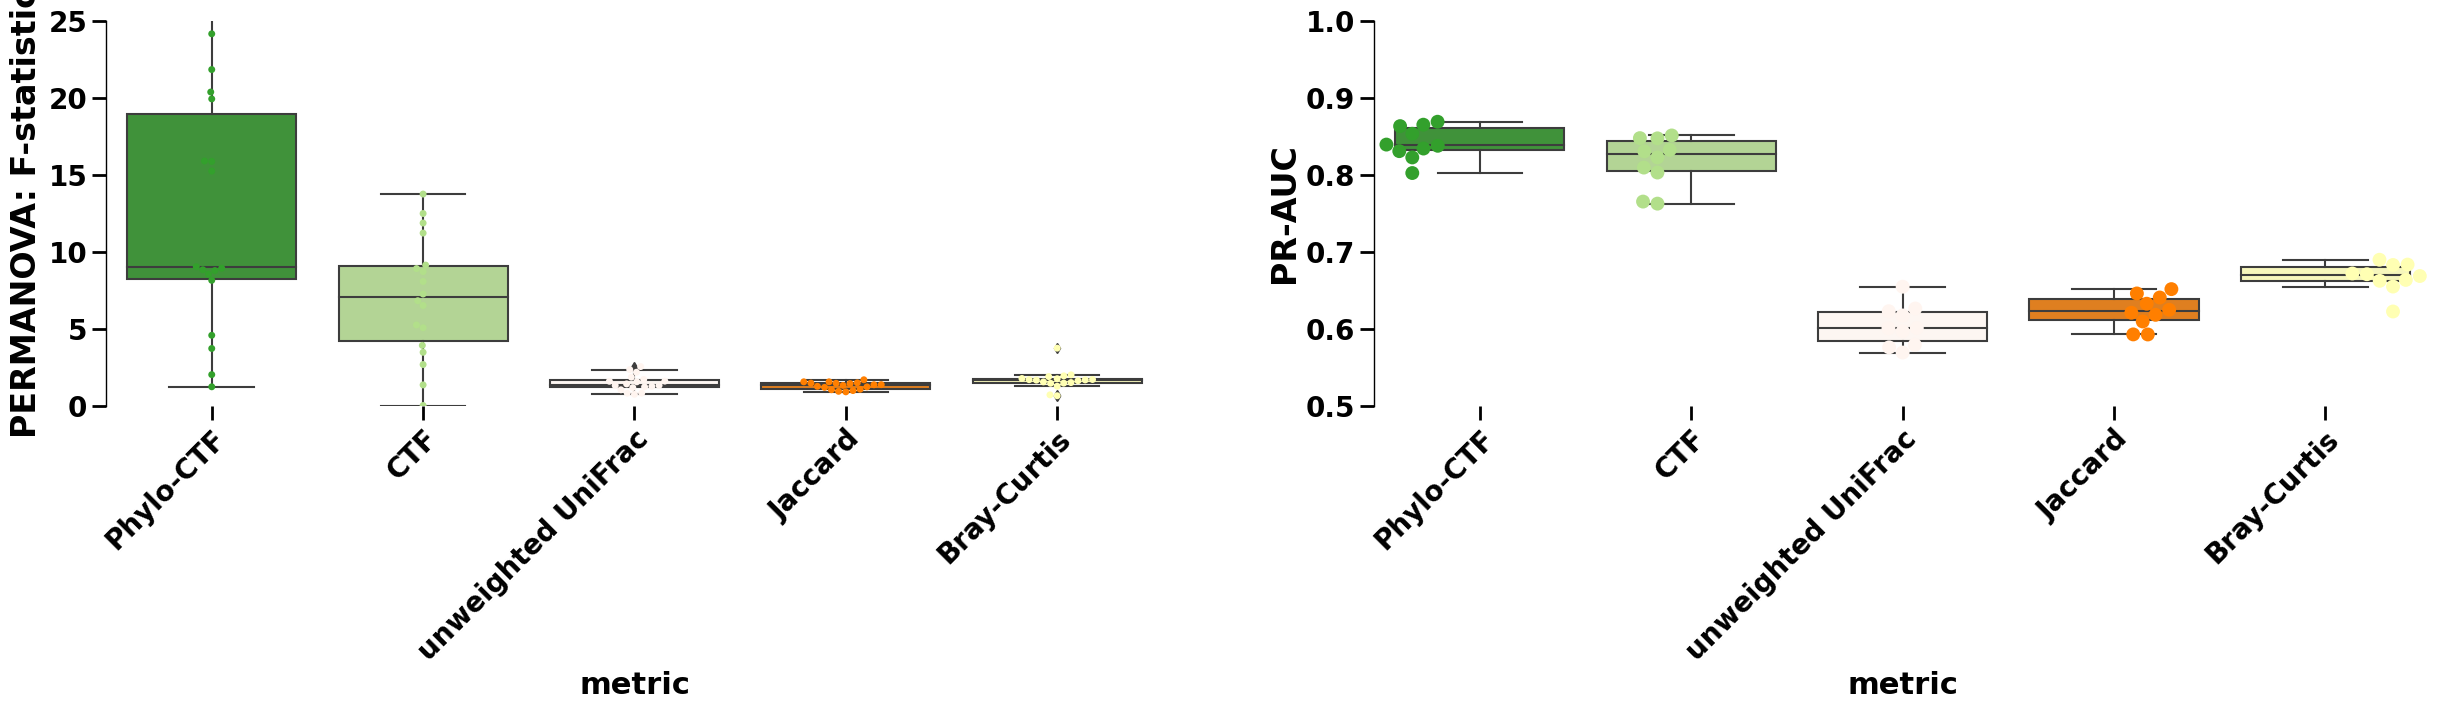

In [10]:
from matplotlib.pyplot import cm

metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' in m.lower()])
metrics_ =  metrics_[:-1][::-1] + [metrics_[-1]]
color = cm.Reds(np.linspace(0, 1, len(metrics_)))
pallete_unifrac = {i:c for i, c in zip(metrics_, color)}
metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' not in m.lower()])
color = cm.Paired(np.linspace(0, 1, len(metrics_)))
pallete_other = {i:c for i, c in zip(metrics_, color)}
pallete_other = {'Phylo-CTF':'#33a02c','CTF':'#b2df8a'}
            
pallete_metric = {**pallete_other, **pallete_unifrac, **{'Jaccard':'#ff7f00',
                                                         'Bray-Curtis':'#ffffb3'}}

fig, axn = plt.subplots(1, 2, figsize=(30, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.boxplot(x='method', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        sns.swarmplot(x='method', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, 25)
        ax.spines['left'].set_bounds(0, 25) 

    else:
        sns.swarmplot(x='method', y='score', palette=pallete_metric,
                      order=pallete_metric.keys(),
                      s=10, data=pltdf, dodge=True, ax=ax)
        sns.boxplot(x='method', y='score', palette=pallete_metric,
                    order=pallete_metric.keys(),
                    data=pltdf, ax=ax, showfliers=False)
        ax.set_ylim(round(pltdf['score'].min() - .05, 1), 1)
        ax.spines['left'].set_bounds(round(pltdf['score'].min() - .05, 1), 1)
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 0.5))

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    for tick in ax.get_yticklabels():
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    ax.set_xlabel('metric',
                  fontsize=22,
                  weight='bold',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  weight='bold',
                  color='black')
plt.savefig('benchmark-ctf.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor())

plt.show()